# TESTING

In [2]:
from utils import *
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.covariance import empirical_covariance

import matplotlib.pyplot as plt

N = 5

data = prepare_mnist_data()
trainX = data['trainX']
trainY = data['trainY']

unique, counts = np.unique(trainY, return_counts=True)
for u,c in zip(unique,counts):
    print(f"class {u}: instances {c}")

def Covariance(X,y):
    N_features = X.shape[1]
    cov_vec = np.zeros(N_features)
    for i in range(X.shape[1]):
        x_i = X[:,i]
        xbar, ybar = x_i.mean(), y.mean()
        cov_vec[i] = np.sum((x_i-xbar)*(y-ybar))/(len(x_i)-1)
    return cov_vec

class 0.0: instances 327
class 3.0: instances 356
class 4.0: instances 317


**CLUSTERING**

(784,)
0.30447099999998545
0.30447100000000005
9497.502784000053


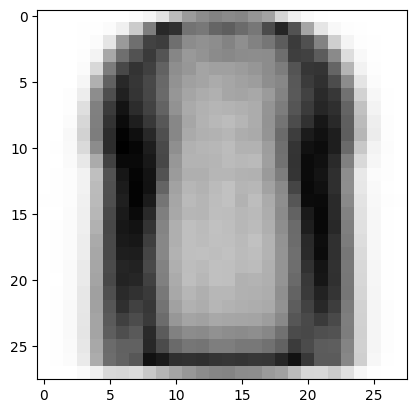

In [3]:
foo = np.var(trainX, axis=0)
print(foo.shape)
print(foo[0])
print(np.var(trainX[:,0]))
print(max(foo))

plt.imshow(np.reshape(foo, (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
plt.show()

**CLASSIFICATION**

In [4]:
# Get dataset unique labels and the sample indices corresponding to those labels
from gekko import GEKKO

unique_labels = np.unique(trainY)
indices_per_label = []
for i, label in enumerate(unique_labels):
    indices = np.where(trainY == label)
    indices_per_label.append(indices)

num_features = 50

# Assume no access to itertools, just use the known possible pairs given the fashion mnist dataset
label_pairs = ((0,1), (0,2), (1,2))

pairwise_covariances = []

# Iterate across all potential label pairs
for (lbl_idx_a, lbl_idx_b) in label_pairs:
    lbl_a = unique_labels[lbl_idx_a]
    lbl_b = unique_labels[lbl_idx_b]

    # Combine sample indices from both classes
    indices = np.append(indices_per_label[lbl_idx_a], indices_per_label[lbl_idx_b])

    # Get X and Y samples from the indices
    X_prime = np.take(trainX, indices, axis=0)
    Y_prime = np.take(trainY, indices)
    
    # print(X_prime.shape)
    # print(Y_prime.shape)

    # relabel original class labels to -1, +1
    for i in range(len(Y_prime)):
        if Y_prime[i] == lbl_a:
            Y_prime[i] = 1
        elif Y_prime[i] == lbl_b:
            Y_prime[i] = -1
    
    # compute covariance for the pair of labels
    pair_covariance = Covariance(X_prime, Y_prime)
    pairwise_covariances.append(np.absolute(pair_covariance))

    # constraints = LinearConstraint
    # selection = cvxpy.Variable(trainX.shape[1])

    # variable = cvxpy.

feature_counts = [5, 20, 80, 320, 784]
selected_features = {}

for feature_count in feature_counts:
    mdl = GEKKO(remote=False)

    # Define max features
    K = mdl.Const(feature_count)

    # Define covariance vector constants
    z_0_1 = [mdl.Const(value=val) for val in pairwise_covariances[0]]
    z_0_2 = [mdl.Const(value=val) for val in pairwise_covariances[1]]
    z_1_2 = [mdl.Const(value=val) for val in pairwise_covariances[2]]

    # Define t_min auxiliary variable
    t_min = mdl.Var(value=0, lb=0)

    # Define pixel selection vector, with its integrality and 0/1 constraints
    # s = [mdl.Var(value=0, lb=0, ub=1, integer=True) for i in range(trainX.shape[1])]
    s = [mdl.Var(value=0, lb=0, ub=1) for i in range(trainX.shape[1])]

    print(len(s))
    # Define constraints
    ## Max number of pixels constraint
    mdl.Equation(np.sum(s) <= K)

    ## Set t_min to the min sum absolute covariance across all class pairs
    # mdl.Equation(t_min <= np.dot(s, z_0_1))
    # mdl.Equation(t_min <= np.dot(s, z_0_2))
    # mdl.Equation(t_min <= np.dot(s, z_1_2))
    ### Reformulate dot products as element-wise multiply and sum to avoid errors in GEKKO
    mdl.Equation(t_min <= mdl.sum([s_i*z_0_1_i for (s_i, z_0_1_i) in zip(s,z_0_1)]))
    mdl.Equation(t_min <= mdl.sum([s_i*z_0_2_i for (s_i, z_0_2_i) in zip(s,z_0_2)]))
    mdl.Equation(t_min <= mdl.sum([s_i*z_1_2_i for (s_i, z_1_2_i) in zip(s,z_1_2)]))

    # Set objective function to maximize t_min
    mdl.Maximize(t_min)
    mdl.options.MAX_ITER = 10000
    mdl.options.SOLVER = 1    
    mdl.options.IMODE = 3
    # mdl.solve(disp=True)
    mdl.solve()

    selected_features[feature_count] = np.array([s_i.value for s_i in s])

784
 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  3
   Constants    :  2353
   Variables    :  3144
   Intermediates:  0
   Connections  :  2355
   Equations    :  2357
   Residuals    :  2357
 
 Number of state variables:    3144
 Number of total equations: -  2359
 Number of slack variables: -  4
 ---------------------------------------
 Degrees of freedom       :    781
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0 -2.98905E-01  5.00000E+00
    1 -2.34153E+02  2.17865E-05
    2 -2.34153E+02  8.88178E-16
    3 -2.34153E+02  8.88178E-16
    4 -2.34153E+02  8.88178E-16
    5 -2.34153E+02  8.88178E-16
 Successful solution
 
 --

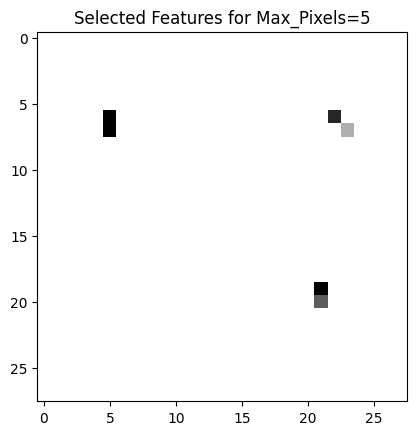

[173 190 201 219 553 581]
Selected Features: 6


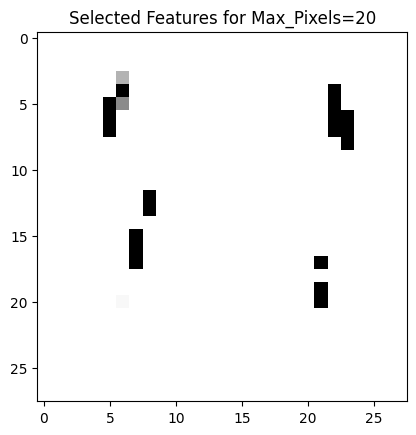

[ 90 118 134 145 146 162 173 190 191 201 218 219 247 344 372 427 455 483
 497 553 566 581]
Selected Features: 22


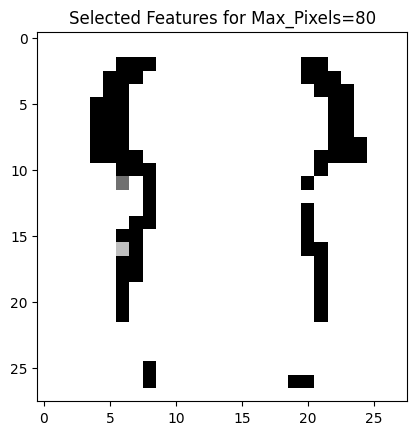

[ 62  63  64  76  77  89  90  91 104 105 106 117 118 133 134 135 144 145
 146 162 163 172 173 174 190 191 200 201 202 218 219 228 229 230 246 247
 248 256 257 258 259 273 274 275 276 286 287 288 301 314 316 328 344 372
 384 399 400 412 426 427 440 454 455 468 469 482 483 497 510 511 525 538
 553 566 581 594 609 708 736 747 748]
Selected Features: 81


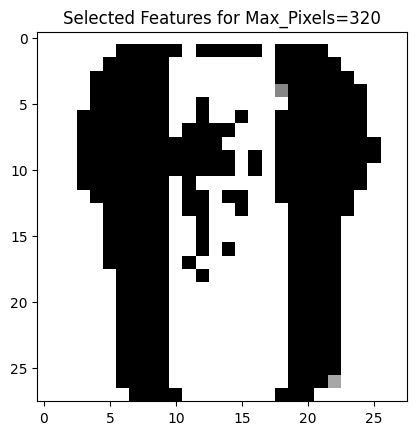

[ 34  35  36  37  38  40  41  42  43  44  46  47  48  49  61  62  63  64
  65  74  75  76  77  78  88  89  90  91  92  93 102 103 104 105 106 107
 116 117 118 119 120 121 130 131 132 133 134 135 136 144 145 146 147 148
 149 152 159 160 161 162 163 164 171 172 173 174 175 176 177 180 183 186
 187 188 189 190 191 192 199 200 201 202 203 204 205 207 208 209 210 214
 215 216 217 218 219 220 227 228 229 230 231 232 233 234 235 236 237 242
 243 244 245 246 247 248 249 255 256 257 258 259 260 261 262 263 264 265
 266 268 270 271 272 273 274 275 276 277 283 284 285 286 287 288 289 290
 291 292 293 294 296 298 299 300 301 302 303 304 311 312 313 314 315 316
 317 319 326 327 328 329 330 331 332 340 341 342 343 344 345 347 348 350
 351 354 355 356 357 358 359 369 370 371 372 373 375 376 379 383 384 385
 386 387 397 398 399 400 401 404 411 412 413 414 425 426 427 428 429 432
 439 440 441 442 453 454 455 456 457 460 462 467 468 469 470 481 482 483
 484 485 487 495 496 497 498 510 511 512 513 516 52

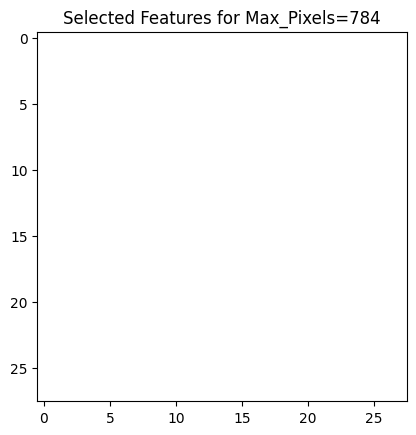

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [5]:
for feature_count in feature_counts:
    features = selected_features[feature_count]
    plt.imshow(np.reshape(features, (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
    plt.title(f"Selected Features for Max_Pixels={feature_count}")
    plt.show()

    feature_indices = np.nonzero(features)[0]
    print(feature_indices)
    print(f"Selected Features: {len(feature_indices)}")
    

**CLUSTERING**

In [8]:
feature_counts = [5, 20, 80, 320, 784]
selected_features = {}

for feature_count in feature_counts:
        # Compute pixel variances
        variance = np.var(trainX, axis=0)

        ## Formulate and run the Integer Linear Program
        mdl = GEKKO(remote=False)

        # Define max number of features
        K = mdl.Const(feature_count)

        # Define covariance vector constants
        z = [mdl.Const(value=val) for val in variance]

        # Define t_min auxiliary variable
        t = mdl.Var(value=0, lb=0)

        # Define pixel selection vector, with its integrality and 0/1 constraints
        s = [mdl.Var(value=0, lb=0, ub=1, integer=True) for i in range(trainX.shape[1])]

        # Define constraints
        ## Max number of pixels constraint
        mdl.Equation(np.sum(s) <= K)
        ## Set t to the sum variance across all selected pixels
        mdl.Equation(t <= mdl.sum([s_i*z_i for (s_i, z_i) in zip(s,z)]))

        # Set objective function to maximize t
        mdl.Maximize(t)
        mdl.options.MAX_ITER = 10000
        mdl.options.SOLVER = 1    
        mdl.options.IMODE = 3
        mdl.solve(disp=True)

        # Get the 1/0 mask of selected features from the final values of s
        feature_mask = np.array([s_i.value for s_i in s])
        
        selected_features[feature_count] = feature_mask

        # Get feature indices of the selected features from the mask
        selected_feature_indices = np.nonzero(feature_mask)[0]



 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  1
   Constants    :  785
   Variables    :  1572
   Intermediates:  0
   Connections  :  785
   Equations    :  787
   Residuals    :  787
 
 Number of state variables:    1572
 Number of total equations: -  787
 Number of slack variables: -  2
 ---------------------------------------
 Degrees of freedom       :    783
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.45 NLPi:    4 Dpth:    0 Lvs:    0 Obj: -4.69E+04 Gap:  0.00E+00
 Successful solution
 
 ---------------------------------------------------
 Solver         :  APOPT (v1.0)
 Solution time  :  0.46959999999999935 sec
 Objective      

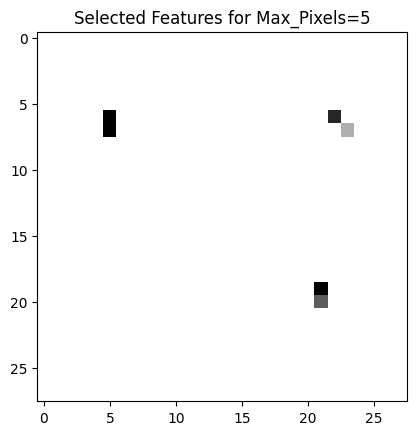

[173 190 201 219 553 581]
Selected Features: 6


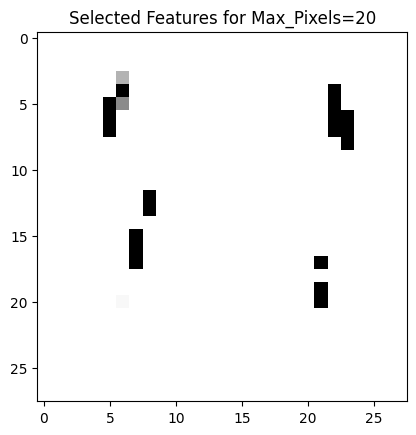

[ 90 118 134 145 146 162 173 190 191 201 218 219 247 344 372 427 455 483
 497 553 566 581]
Selected Features: 22


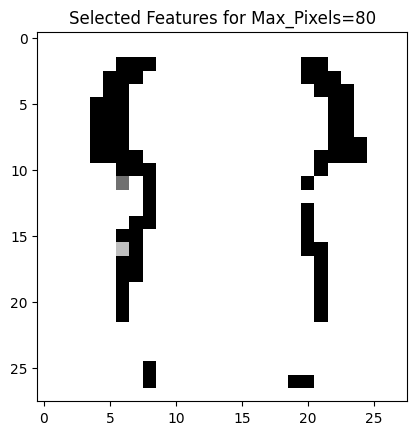

[ 62  63  64  76  77  89  90  91 104 105 106 117 118 133 134 135 144 145
 146 162 163 172 173 174 190 191 200 201 202 218 219 228 229 230 246 247
 248 256 257 258 259 273 274 275 276 286 287 288 301 314 316 328 344 372
 384 399 400 412 426 427 440 454 455 468 469 482 483 497 510 511 525 538
 553 566 581 594 609 708 736 747 748]
Selected Features: 81


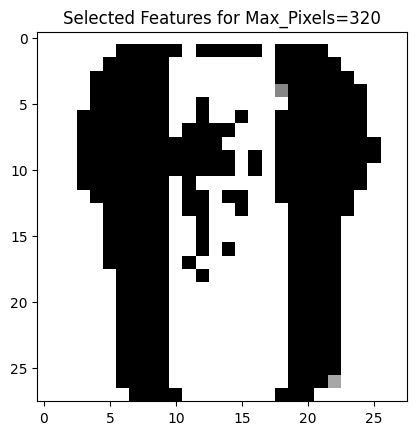

[ 34  35  36  37  38  40  41  42  43  44  46  47  48  49  61  62  63  64
  65  74  75  76  77  78  88  89  90  91  92  93 102 103 104 105 106 107
 116 117 118 119 120 121 130 131 132 133 134 135 136 144 145 146 147 148
 149 152 159 160 161 162 163 164 171 172 173 174 175 176 177 180 183 186
 187 188 189 190 191 192 199 200 201 202 203 204 205 207 208 209 210 214
 215 216 217 218 219 220 227 228 229 230 231 232 233 234 235 236 237 242
 243 244 245 246 247 248 249 255 256 257 258 259 260 261 262 263 264 265
 266 268 270 271 272 273 274 275 276 277 283 284 285 286 287 288 289 290
 291 292 293 294 296 298 299 300 301 302 303 304 311 312 313 314 315 316
 317 319 326 327 328 329 330 331 332 340 341 342 343 344 345 347 348 350
 351 354 355 356 357 358 359 369 370 371 372 373 375 376 379 383 384 385
 386 387 397 398 399 400 401 404 411 412 413 414 425 426 427 428 429 432
 439 440 441 442 453 454 455 456 457 460 462 467 468 469 470 481 482 483
 484 485 487 495 496 497 498 510 511 512 513 516 52

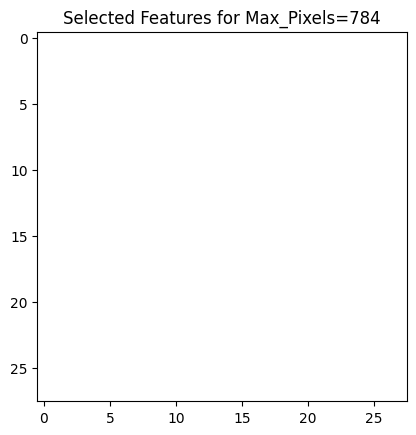

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [6]:
for feature_count in feature_counts:
    features = selected_features[feature_count]
    plt.imshow(np.reshape(features, (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
    plt.title(f"Selected Features for Max_Pixels={feature_count}")
    plt.show()

    feature_indices = np.nonzero(features)[0]
    print(feature_indices)
    print(f"Selected Features: {len(feature_indices)}")